# Большое практическое задание 1
# Классификация изображений цифр метрическими методами

## курс "Машинное обучение 1", программа AIMasters, 2022

## Студент: Хоружев Илья Максимович

## Реализация алгоритмов (10 баллов)

Прототипы функций должны строго соответствовать прототипам, описанным в спецификации и проходить
все выданные тесты. Задание, не проходящее все выданные тесты, приравнивается к невыполненному. При
написании **необходимо пользоваться** стандартными средствами языка Python и библиотекой numpy. Библиотеками scipy и scikit-learn пользоваться **запрещено**, если это не обговорено отдельно в пункте задания. Для
экспериментов в бонусной части разрешается пользоваться любыми открытыми библиотеками, реализующими
алгоритмы обработки изображений.

Среди предоставленных файлов должны быть следующие модули и функции в них

1. Модуль `knn.distances` с реализацией функции для вычисления расстояния:
    1. `euclidean_distance(X, Y)` — реализация евклидова расстояния с заданными свойствами;
    2. `cosine_distance(X, Y)` — реализация косинусного расстояния с заданными свойствами;


2. Модуль `knn.nearest_neighbors`, содержащий собственную реализацию поиска ближайших соседей.
    
    Класс `NearestNeighborsFinder` с методами:
      1. `__init__(self, n_neighbors, metric="euclidean")` — конструктор (инициализатор) класса;
      2. `fit(self, X, y=None)` — обучение алгоритма;
      3. `kneighbors(self, X, return_distance=False)` — поиск ближайших соседей.


3. Модуль `knn.classification`, содержащий собственную реализацию классификатора на основе метода ближайших соседей.

    Класс `KNNClassifier` с методами:
    
    1. `__init__(self, n_neighbors, algorithm=’my_own’, metric=’euclidean’, weights=’uniform’)` — конструктор (инициализатор) класса;
    2. `fit(self, X, y=None)` — обучение алгоритма;
    3. `kneighbors(self, X, return_distance=False)` — поиск ближайших соседей;
    4. `predict(self, X)` — редсказание на новых данных;
    5. `_predict_precomputed(self, indices, distances)` — вспомогательный метод.
    
   Класс `BatchedKNNClassifier`, полезный для работы с большими выборками, с методами:
   
    1. `__init__(self, n_neighbors, algorithm=’my_own’, metric=’euclidean’, weights=’uniform’, batch_size=None)` — конструктор (инициализатор) класса
    2. `kneighbors(self, X, return_distance=False)` — поиск ближайших соседей, разбитый на несколько итераций по батчам
    3. `set_batch_size(self, batch_size)` — метод для выставления нового значения размера батча


4. Модуль `knn.model_selection` с реализациями функций для применения кросс-валидации:

    1. `knn_cross_val_score(X, y, k_list, scoring, cv=None, **kwargs)` — функция для измерения качества на кросс-валидации.

Ожидается, что реализациия всех классов и функций будет максимально эффективной. Дополнительно вам предоставлены открытые unit-тесты, которые находятся рядом с модулем `knn` в директории `tests` Чтобы запустить тесты в консоли требуется выполнить одну из команд:


```
$ python -m unittest                            # запуск всех тестов
$ python -m unittest tests/test_distances.py    # запуск конкретных тестов
```

## Эксперименты (15 баллов)

Здесь вы можете заимпортировать всё, что вам потребуется для экспериментов:

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from knn.distances import euclidean_distance, cosine_distance 
from knn.classification import BatchedKNNClassifier
from knn.model_selection import knn_cross_val_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from time import time

### 1. Загрузка даннных

Эксперименты этого задания необходимо проводить на датасете MNIST. Загрузить датасет можно при помощи функции `sklearn.datasets.fetch_openml("mnist_784")` или скачать вручную с сайта
http://yann.lecun.com/exdb/mnist/. Датасет необходимо разбить на обучающую выборку (первые 60 тыс.
объектов) и тестовую выборку (10 тыс. последних объектов).

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1/7, shuffle = False)
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
X_train.shape[0]

60000

### 2. Исследование скорости методов поиска (4 балла)

Исследуйте, какой алгоритм поиска ближайших соседей будет быстрее работать в различных ситуациях.

Измерьте для каждого алгоритма поиска (`kd_tree`, `ball_tree`, `brute` и `my_own`) время нахождения 5 ближайших соседей для каждого объекта тестовой выборки по евклидовой метрике. Выберите подмножество признаков, по которому будет считаться расстояние, размера 10, 20, 100 (подмножество признаков выбирается один раз для всех объектов, случайно).

**Замечание.** Для оценки времени долго работающих функций можно пользоваться либо функциями из
модуля time, либо magic-командой %time, которая запускает код лишь один раз.

In [8]:
my_own_time, brute_time, ball_tree_time, kd_tree_time = [], [], [], []
num_features = [10, 20, 100]
feature_indices = np.arange(784)
for i in num_features:
    indices = np.random.choice(feature_indices, i, replace=False)
    model = BatchedKNNClassifier(5, batch_size=500)
    model.fit(X_train[:,indices], y_train)
    time_1 = time()
    model.kneighbors(X_test[:, indices])
    time_2 = time()
    my_own_time.append(time_2 - time_1)
    model = BatchedKNNClassifier(5, algorithm='brute', batch_size=500)
    model.fit(X_train[:,indices], y_train)
    time_1 = time()
    model.kneighbors(X_test[:, indices])
    time_2 = time()
    brute_time.append(time_2 - time_1)
    model = BatchedKNNClassifier(5, algorithm='ball_tree', batch_size=500)
    model.fit(X_train[:,indices], y_train)
    time_1 = time()
    model.kneighbors(X_test[:, indices])
    time_2 = time()
    ball_tree_time.append(time_2 - time_1)
    model = BatchedKNNClassifier(5,  algorithm='kd_tree', batch_size=500)
    model.fit(X_train[:,indices], y_train)
    time_1 = time()
    model.kneighbors(X_test[:, indices])
    time_2 = time()
    kd_tree_time.append(time_2 - time_1)

#### Приведите график / таблицу с результатами вашего эксперимента

In [22]:
time_df = pd.DataFrame([num_features, my_own_time, brute_time, ball_tree_time, kd_tree_time])
time_df = time_df.transpose()
time_df.columns = ["Число признаков", "my_own", "brute", "ball_tree", "kd_tree"] 
time_df = time_df.set_index('Число признаков')
time_df

,my_own,brute,ball_tree,kd_tree
Число признаков,,,,
10.0,9.819469,8.631418,2.198734,1.852899
20.0,11.139439,9.993133,10.950515,4.497061
100.0,12.716876,11.738484,114.056754,120.567277


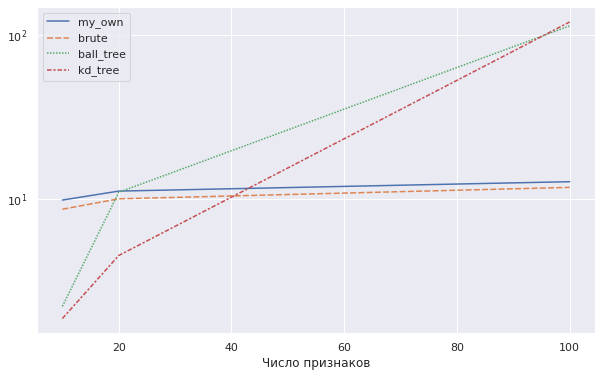

In [33]:
plt.rcParams['figure.figsize']=(10,6)
g = sns.lineplot(data=time_df)
g.set_yscale('log')
plt.show()

#### Ответьте на следующие вопросы

1. Какой алгоритм сработал быстрее всего для каждого из размера подвыборок? Ожидали ли вы такие результаты до проведения эксперимента?

Для подмножеств, состоящих из 10 и 20 признаков наиболее быстрым оказался алгоритv - kd-tree. Для подмножества из 100 признаков лучший результат дал brute поиск с малым преимуществом над my_own.

Нет, ожидал, что kd-tree будет быстрее во всех случаях.

2. Приведите теоретическую сложность каждого из алгоритмов поиска. Согласуется ли время работы алгоритмов на практике с их теоретической вычислительной сложностью? Как вы думаете, почему?

Алгоритм kd-tree имеет сложность построения  - $O(d\cdot n\log n)$, если делить по пространство на два по медиане для каждый раз (n - размер обучающей выборки, d - число признаков). Сложность построения для алгоритма ball-tree тоже $O(d\cdot n\log n)$. Для brute и my_own поиска сложность поиска - $O(d\cdot n)$.

Исходя из графика, можно сказать, что время работы алгоритмов на практике согласуются с их теоретической вычислительной сложностью.

3. Какой алгоритм исходя из результатов эксперимента следует использовать в дальнейшем? Выберите алгоритм поиска соседей, который вы будете использовать во всех экспериментах ниже. 

Исходя из того, что в дальнейшем будут использоваться все 784 признака - выберу brute алгоритм, так как он чуть опережает по времени собственную реализацию.

### 3. Исследование зависимости точности алгоритма на кросс-валидации (4 балла)


Оцените по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) алгоритма k ближайших соседей в зависимости от следующих факторов:
* количество соседей k от 1 до 10
* используется евклидова или косинусная метрика

In [26]:
k_range = np.arange(1, 11)
euclid_val_score = knn_cross_val_score(X_train, y_train, k_range, scoring='accuracy', cv=KFold(3), algorithm='brute', metric='euclidean', batch_size=500)
cosine_val_score = knn_cross_val_score(X_train, y_train, k_range, scoring='accuracy', cv=KFold(3), algorithm='brute', metric='cosine', batch_size=500)

#### Нарисуйте график зависимости точности от количества соседей по каждой метрике

In [38]:
df_acc_euc = pd.DataFrame(('uniform', 'euclid', key, value) for key, value_l in euclid_val_score.items() for value in value_l)
df_acc_cos = pd.DataFrame(('uniform', 'cosine', key, value) for key, value_l in cosine_val_score.items() for value in value_l)
df_acc = pd.concat([df_acc_euc, df_acc_cos], axis=0)
df_acc.columns = ['weight', 'metric','K-neighbours', 'Accuracy'] 

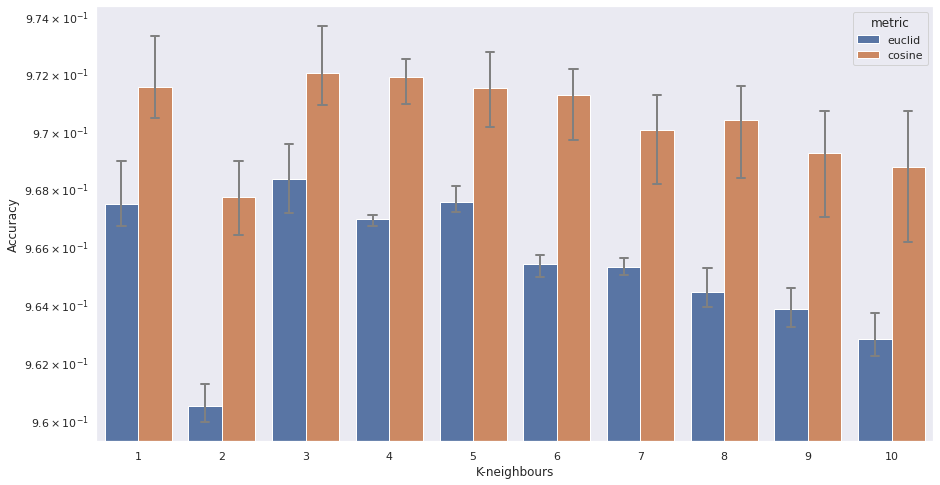

In [39]:
plt.rcParams['figure.figsize']=(15,8)
g = sns.barplot(data=df_acc, x='K-neighbours', y='Accuracy', 
                hue='metric',
                errcolor = 'gray', errwidth = 2, 
                capsize = 0.1)
g.set_yscale('log')
plt.show()

#### Ответьте на следующие вопросы

1. По результатам эксперимента, какие гиперпараметры вы считаете наиболее оптимальными? Обоснуйте свой выбор (например, если у вас несколько наборов параметров с высоким качеством, обоснуйте как вы выберите среди этих наборов один).

Наиболее оптимальными параметрами считаю - k = 3, 4, 5. Причем k = 4 кажется более оптимальным в связи с меньшим разбросом в результатах кросс-валидации (можно предположить, что чуть более обобщенно предсказывает) и с высоким показателем точности для косинусной метрики.


2. Какая метрика лучше себя показала в экспериментах? Можете ли вы объяснить, почему?

Косинусное расстояние показало себя лучше в экспериментах. Это может быть связано с проклятием размерности для евклидовой метрики. В данном случае направление будет более информативно, чем расстояние между обьектами. Далее буду использовать косинусное расстояние.
    
   
2. Есть ли на графике зависимости точности от количество соседей "выбросы", резкие падения/повышения качества для одного значения k по сравнению с соседними? Если да, предположите причину появления этих выбросов.

Да, для k = 2 заметно падение в качестве. Это может быть связано с случайным выбором между двумя ближайшими соседями, так как они имеют одинаковый вес (В следующем эксперименте данное прдеположение подтверждается, для взвешенного выбора спада не наблюдается)

### 3. Исследование зависимости точности взвешенного алгоритма на кросс-валидации (4 балла)

По результатам предыдущего эксперимента выберите метрику, которую вы будете использовать в этом эксперименте.

Оцените по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) взвешенного алгоритма k ближайших соседей в зависимости от количество соседей k (от 1 до 10).

Голос объекта положите равным `1 / (distance + eps)`, где `eps` = `1e-5`.

In [37]:
cosine_val_score_weighted = knn_cross_val_score(X_train, y_train, k_range, scoring='accuracy', cv=KFold(3), algorithm='brute', metric='cosine', weights='distance', batch_size=500)

#### Нарисуйте график зависимости точности от количества соседей 

In [40]:
df_acc_cos_weighted = pd.DataFrame(('distance', 'cosine', key, value) for key, value_l in cosine_val_score_weighted.items() for value in value_l)
df_acc_weights = pd.concat([df_acc_cos, df_acc_cos_weighted], axis=0)
df_acc_weights.columns = ['weight', 'metric', 'K-neighbours', 'Accuracy'] 

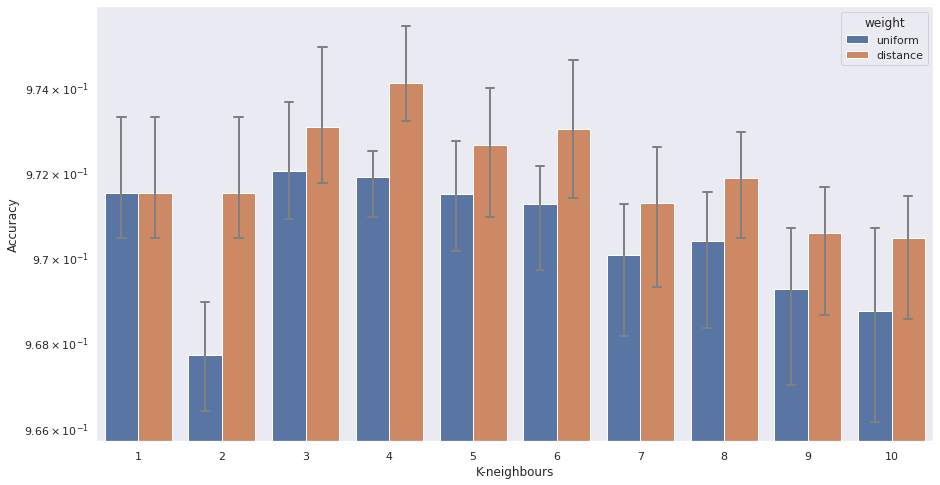

In [41]:
plt.rcParams['figure.figsize']=(15,8)
g = sns.barplot(data=df_acc_weights, x='K-neighbours', y='Accuracy', 
                hue='weight',
                errcolor = 'gray', errwidth = 2, 
                capsize = 0.1)
g.set_yscale('log')
plt.show()

#### Ответьте на следующие вопросы

1. По результатам эксперимента, какие гиперпараметры вы считаете наиболее оптимальными? Обоснуйте свой выбор.

Как можно увидеть из графика, максимум точности достигается для k = 4, что подтверждает оптимальность данного гипперпараметра с совместным использованием косинусного расстояния


2. Сравните результаты взвешенного алгоритма с невзвешенным. Объясните разницу/отсутствие разницы в результатах.

Результат взвешенного алгоритма для всех k > 1 дал лучшие показатели в точности. Это связано с отсутствием случайности выбора между некоторыми и классами и учетом обьектов среди k ближайших, которые сильнее схожи по направлению к тестируемому.

### 4. Применение алгоритма и интерпретация ошибок (3 балла)

1. Примените лучший алгоритм к исходной обучающей и тестовой выборке и посчитайте точность классификации. Сравните с точностью по кросс-валидации. Опишите ваши результаты.

In [158]:
model = BatchedKNNClassifier(4, metric='cosine', weights='distance', batch_size=500)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
print('Точность на тесте: {}, средняя точность на кросс-валидации: {}'.format(accuracy_score(y_test, y_predicted), np.mean(cosine_val_score_weighted[4])))

Точность на тесте: 0.9752, средняя точность на кросс-валидации: 0.9741


Точность на тесте получилась чуть лучше, что свидетельствует об отсутствии переобучения.

2. Постройте и проанализируйте матрицу ошибок (confusion matrix), используйте функцию `sklearn.metrics.confusion_matrix`. Визуализируйте несколько объектов из тестовой выборки, на которых были допущены ошибки. Проанализируйте и укажите их общие черты.

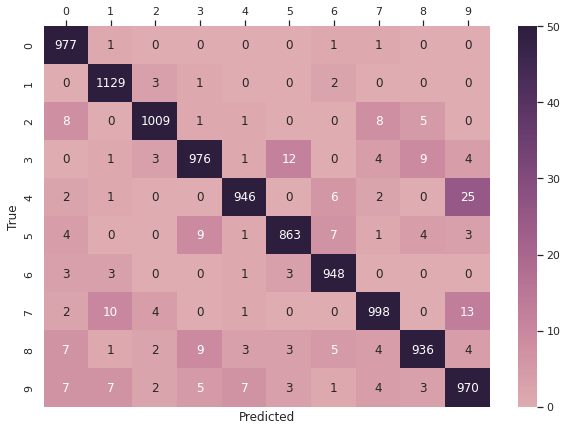

In [156]:
err_df = pd.DataFrame(confusion_matrix(y_test, y_predicted))
plt.rcParams['figure.figsize']=(10,7)
ax = sns.heatmap(err_df, annot=True, 
                 vmin=0, vmax=50, center=20,
                 cmap=sns.cubehelix_palette(as_cmap=True), fmt="d")
ax.set(xlabel="Predicted", ylabel="True")
ax.xaxis.tick_top()
plt.show()

In [143]:
err_4_9, err_7_9, err_7_1, err_3_5 = 0, 0, 0, 0
for i, (true, pred) in enumerate(zip(y_test, y_predicted)):
    if int(true) == 4 and int(pred) == 9 and not err_4_9:
        err_4_9 = i
    if int(true) == 7 and int(pred) == 9:
        err_7_9 = i
    if int(true) == 7 and int(pred) == 1:
        err_7_1 = i
    if int(true) == 3 and int(pred) == 5 and not err_3_5:
        err_3_5 = i

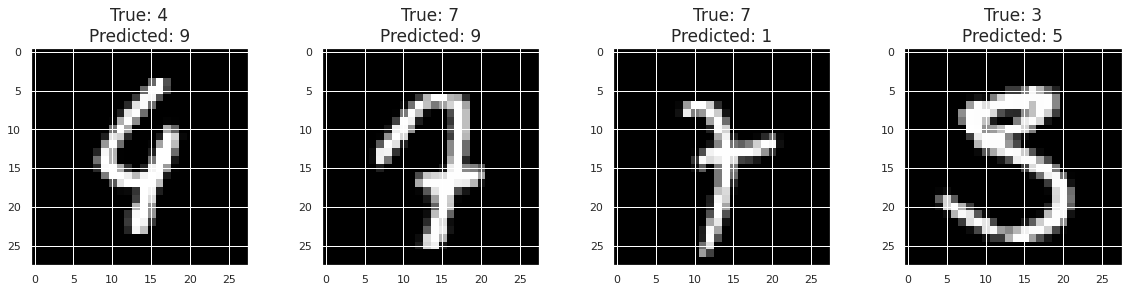

In [154]:
plt.figure(figsize=(20,4))
for index, elem in enumerate([err_4_9, err_7_9, err_7_1, err_3_5]):
    plt.subplot(1, 4, index + 1)
    plt.imshow(np.reshape(X_test[elem], (28,28)), cmap=plt.cm.gray)
    plt.title('True: {}\nPredicted: {}'.format(y_test[elem], y_predicted[elem]), fontsize=17)

Исходя из confusion матрицы я вывел 4 наиболее встречаемые ошибки для алгоритма. Судя по картинкам можно сделать вывод, что алгоритм ошибается на небрежно написанных цифрах, а именно - когда они напоминают другие цифры (если добавить или убрать малую черту для цифр). Получается, что алгоритм достаточно естественным путем решает задачу классификации.

---------------------------------------------------------------------------------------------